In [80]:
import os
import urllib.request
import json
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from reportlab.pdfgen import canvas
from reportlab.platypus import (SimpleDocTemplate, Paragraph, PageBreak, Image, Spacer, Table, TableStyle, KeepInFrame, Frame)
from reportlab.lib.enums import TA_LEFT, TA_RIGHT, TA_CENTER, TA_JUSTIFY
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet
from reportlab.lib.pagesizes import LETTER, inch
from reportlab.graphics.shapes import Line, LineShape, Drawing
from reportlab.lib.colors import Color
from reportlab.pdfbase.acroform import AcroForm
from reportlab.lib import colors
from reportlab.platypus.flowables import Flowable
import PIL

In [81]:
def import_json_to_dict(url) :
    response = urllib.request.urlopen(url)
    my_dict = json.loads(response.read())
    return my_dict

In [82]:
def mkdir_ifnotexist(path) :
    if not os.path.isdir(path) :
        os.mkdir(path)

In [83]:
def format_amount(indic, valeur):
    if "Montant" in indic:
        f_valeur = float(valeur)
        if f_valeur > 1000000:
            return str(round(f_valeur/1000000, 1)) + ' M€'
        elif f_valeur > 10000:
            return str(round(f_valeur/1000, 1)) + ' k€'
        else:
            return str(f_valeur)
    else:
        try:
            return int(valeur.split(".")[0])
        except ValueError as err:
            print(f"L'indicateur {indic} possède des valeurs invalides : {err}")

In [84]:
mailles = ["national", "regional", "departemental"]

In [85]:
pp_dep = pd.read_csv("pp_dep.csv", sep=";", dtype={"reg":str, "dep":str})

In [86]:
list_mesure_indic = list(pp_dep.pivot_table(index=["short_mesure", "short_indic"], values="valeur").index)

In [87]:
short_mesures_to_keep =set([
'AAP et AMI Efficacité énergétique',
'Assurance prospection',
"Ma Prime Rénov'",
"Prime à l'embauche des jeunes",
"Prime à l'embauche pour les travailleurs handicapés",
"Apprentissage",
"Bonus électrique",
"Contrats Initiatives Emploi (CIE) Jeunes",
'Contrats de professionnalisation',
'France Num : aide à la numérisation des TPE,PME,ETI',
'Garantie jeunes',
"AAP industrie : Modernisation des filières auto et aéro",
"Parcours emploi compétences (PEC) Jeunes",
'Prime à la conversion des véhicules légers',
"AAP Industrie : Soutien aux projets industriels territoires",
"AAP Industrie : Sécurisation approvisionnements critiques",
"Renforcement subventions Business France",
'Rénovation des bâtiments Etats (marchés notifiés)',
"Service civique",
'Soutien recherche aéronautique civil'
])
#print(list_mesure_indic)
#print(list(x[0] for x in list_mesure_indic if not(x[0] in short_mesures_to_keep)))
list_mesure_indic = [x for x in list_mesure_indic if x[0] in short_mesures_to_keep]

In [88]:
r = "|".join(short_mesures_to_keep)
r

"AAP industrie : Modernisation des filières auto et aéro|Renforcement subventions Business France|Bonus électrique|Assurance prospection|Apprentissage|Prime à l'embauche pour les travailleurs handicapés|France Num : aide à la numérisation des TPE,PME,ETI|Contrats de professionnalisation|Prime à l'embauche des jeunes|Rénovation des bâtiments Etats (marchés notifiés)|Prime à la conversion des véhicules légers|Parcours emploi compétences (PEC) Jeunes|AAP Industrie : Sécurisation approvisionnements critiques|Service civique|Ma Prime Rénov'|AAP Industrie : Soutien aux projets industriels territoires|Garantie jeunes|Contrats Initiatives Emploi (CIE) Jeunes|Soutien recherche aéronautique civil|AAP et AMI Efficacité énergétique"

In [89]:
pp_dep.shape

(15174, 15)

In [90]:
pp_dep2 = pp_dep.loc[pp_dep.short_mesure.str.contains(r)]
print(pp_dep2.shape)
print(pp_dep2.valeur.isna().sum())

(10364, 15)
0


/home/yves/anaconda3/envs/propilot/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [91]:
pp_dep2.short_mesure.unique()

array(['Service civique', 'Soutien recherche aéronautique civil',
       'Prime à la conversion des véhicules légers',
       'AAP et AMI Efficacité énergétique', 'Bonus électrique',
       "Ma Prime Rénov'",
       'AAP industrie : Modernisation des filières auto et aéro',
       'Renforcement subventions Business France',
       'France Num : aide à la numérisation des TPE,PME,ETI',
       'Assurance prospection',
       'AAP Industrie : Sécurisation approvisionnements critiques',
       'AAP Industrie : Soutien aux projets industriels territoires',
       "Prime à l'embauche des jeunes", 'Apprentissage',
       'Contrats de professionnalisation',
       "Prime à l'embauche pour les travailleurs handicapés",
       'Garantie jeunes'], dtype=object)

In [92]:
pp_dep2.loc[pp_dep2.valeur.isna()].head(20)

,Unnamed: 0,indicateur,state_id,period_date,period_month_tri,Date,valeur,departement,mesure,short_indic,short_mesure,dep,reg,libelle,region


In [65]:
pp_reg = pd.pivot_table(pp_dep, index=["mesure","short_mesure", "reg","region", "Date", "period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_reg.rename(columns={"reg":"libelle"}, inplace=True)
pp_reg.reset_index(inplace=True)

In [66]:
pp_nat = pd.pivot_table(pp_reg, index=["mesure", "short_mesure", "Date","period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_nat.reset_index(inplace=True)

In [67]:
dict_mesure_indic = {}
for x in list_mesure_indic:
    if x[0] in dict_mesure_indic:
        dict_mesure_indic[x[0]].append(x[1])
    else:
        dict_mesure_indic[x[0]] = [x[1]]

In [68]:
dict_mesure_indic['AAP Industrie : Soutien aux projets industriels territoires'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP Industrie : Sécurisation approvisionnements critiques'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP et AMI Efficacité énergétique'] = ["Nombre d'entreprises ayant reçu l'aide"]
dict_mesure_indic['AAP industrie : Modernisation des filières auto et aéro'] = ['Nombre de PME']

In [69]:
# On ne veut pas afficher les lignes de Prime Rénov nulles
pp_dep = pp_dep.loc[(pp_dep.short_mesure != "Ma Prime Rénov'") | (pp_dep.valeur != 0) ]

In [70]:
pp_dep.valeur = pp_dep.valeur.astype(str)
pp_dep.valeur = pp_dep.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [71]:
pp_reg.valeur = pp_reg.valeur.astype(str)
pp_reg.valeur = pp_reg.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [72]:
pp_nat.valeur = pp_nat.valeur.astype(str)
pp_nat.valeur = pp_nat.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [73]:
taxo_dep_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/departements-minify.json'
taxo_reg_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/regions-minify.json'

In [74]:
taxo_dep_df = pd.DataFrame(import_json_to_dict(taxo_dep_url))
dep_list = list(taxo_dep_df['dep'])
print('{} departements.'.format(len(dep_list)))

taxo_reg_df = pd.DataFrame(import_json_to_dict(taxo_reg_url))
reg_list = list(taxo_reg_df['reg'])
print('{} regions.'.format(len(reg_list)))

101 departements.
18 regions.


In [75]:
#Building the folders structures
pp_img_dir_path = './pp_img'
img_dir_path = './img/'
reports_dir_path = './reports/'

mkdir_ifnotexist(pp_img_dir_path)
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national'))
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national', 'France'))

#Regions subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional'))
for reg in reg_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional', reg))
    
#Departements subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental'))
for dep in dep_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental', dep))

mkdir_ifnotexist(reports_dir_path)

In [76]:
taxo_dep_df

,cheflieu,dep,libelle,ncc,nccenr,reg,tncc
0,01053,01,Ain,AIN,Ain,84,5
1,02408,02,Aisne,AISNE,Aisne,32,5
2,03190,03,Allier,ALLIER,Allier,84,5
3,04070,04,Alpes-de-Haute-Provence,ALPES DE HAUTE PROVENCE,Alpes-de-Haute-Provence,93,4
4,05061,05,Hautes-Alpes,HAUTES ALPES,Hautes-Alpes,93,4
...,...,...,...,...,...,...,...
96,97105,971,Guadeloupe,GUADELOUPE,Guadeloupe,01,3
97,97209,972,Martinique,MARTINIQUE,Martinique,02,3
98,97302,973,Guyane,GUYANE,Guyane,03,3
99,97411,974,La Réunion,LA REUNION,La Réunion,04,0


In [77]:
all_charts_as_df = {"departemental": {dep: [] for dep in dep_list},
                   "national": {'France': []},
                   "regional": {reg: [] for reg in reg_list}}

In [78]:
mesure = 'Apprentissage'
short_indics = dict_mesure_indic[mesure]
chs = make_pp_chart('national', mesure, short_indics)

Plotting country Apprentissage-['Nombre de contrats d’apprentissage']


In [41]:
def make_pp_chart(maille, mesure, short_indics):
    """ Renvoie un DataFrame regroupant les valeurs des indicateurs pour une mesure donnée au niveau d'une maille donnée."""
    
    charts = []
    if maille == "departemental":
        df = pp_dep.loc[(pp_dep.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        deps = taxo_dep_df.dep.unique()  # Liste exhaustive de départements
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indics] = '-'
        default = default[["Date"] + short_indics]

        for dep in deps:
            print(f"Plotting {mesure}-{short_indics} : departement {dep}")
            df_dep = df.loc[df.dep == dep]
            if df_dep.shape[0] == 0:
                charts.append(default)
            else:
                df_plot = pd.pivot_table(df_dep, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
                df_plot = df_plot.reset_index().drop('period_date', axis=1)
                df_plot = df_plot.rename_axis(None, axis=1)
                df_plot = df_plot.fillna('-')
                df_plot = df_plot[['Date'] + short_indics]
                charts.append(df_plot)
            
    elif maille == "regional":
        df = pp_reg.loc[(pp_reg.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        regs = df.reg.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indics] = '-'
        default = default[["Date"] + short_indics]

        for reg in regs:
            print(f"Plotting region {mesure}-{short_indics} : {reg}")
            df_reg = df.loc[df.reg == reg]
            if df_reg.shape[0] == 0:
                charts.append(default)
            else:
                df_plot = pd.pivot_table(df_reg, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
                df_plot = df_plot.reset_index().drop('period_date', axis=1)
                df_plot = df_plot.rename_axis(None, axis=1)
                df_plot = df_plot.fillna('-')
                df_plot = df_plot[['Date'] + short_indics]
                charts.append(df_plot)
            
    elif maille == "national":
        print(f"Plotting country {mesure}-{short_indics}")
        df_nat = pp_nat.loc[(pp_nat.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        df_plot = pd.pivot_table(df_nat, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
        df_plot = df_plot.reset_index().drop('period_date', axis=1)
        df_plot = df_plot.rename_axis(None, axis=1)
        df_plot = df_plot.fillna('-')
        df_plot = df_plot[['Date'] + short_indics]
        charts.append(df_plot)
    return charts

In [26]:
def format_col_labels(col_names_src, max_num_lines=3, num_char_threshold=14):
    """ Ajoute des retours à la ligne aux noms de colonnes pour réduire la largeur du texte 
    dans l'image. 
    :param str col_names_src: Liste des noms de colonnes.
    :param int max_num_lines: Nombre de lignes max. On n'ajoute plus de retour à la ligne par la suite.
    :param int num_char_threshold: Un retour à la ligne est ajouté dès lors que ce nombre de chars est atteint.
    """
    col_names = []
    for col_name_src in col_names_src:
        col_name = ''
        num_lines = 1
        num_chars_per_line = 0
        for word in col_name_src.split(' '):
            col_name += (word + ' ')
            num_chars_per_line += (len(word) + 1)
            if num_chars_per_line >= num_char_threshold and num_lines < max_num_lines:
                col_name += '\n'
                num_lines += 1
                num_chars_per_line = 0
        col_names.append(col_name.strip())
    return col_names


def pp_plot(data, col_width=7, row_height=1.4, font_size=20,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    # Réduire la largeur des colonnes
    col_names = format_col_labels(data.columns)
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=col_names, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

In [27]:
def save_pp_plot(maille, geo, mesure, ax):
    #print(maille, geo, mesure)
    path = os.path.join("pp_img", maille, geo)
    ax.figure.savefig(os.path.join(path, "{}.png".format(mesure)))
    plt.close()

In [28]:
def make_all_charts():
    for short_mesure in dict_mesure_indic:
        short_indics = dict_mesure_indic[short_mesure]
        for maille in mailles :
            make_pp_chart(maille, short_mesure, short_indics)

Plotting country AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires']
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 11
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 52
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 27
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 28
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 01
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 84
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 44
Plotting region AAP Industrie : Sout

KeyboardInterrupt: 

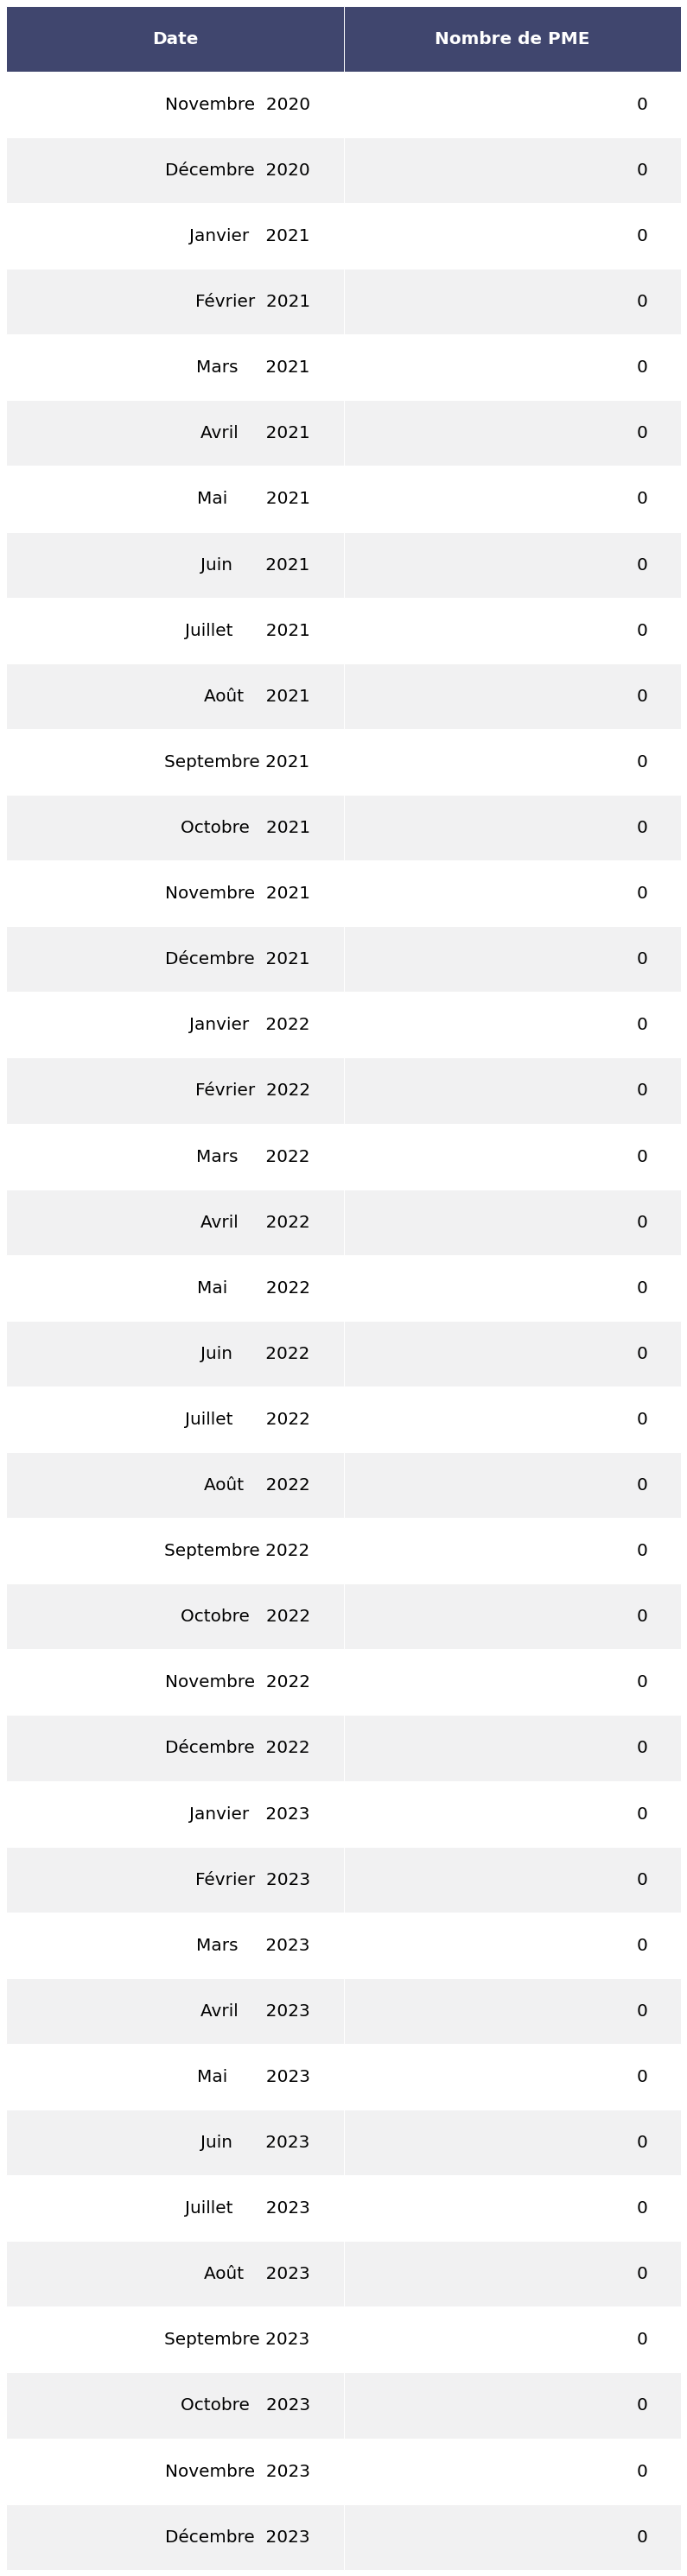

In [29]:
make_all_charts()

In [58]:
volet2mesures = {
'Ecologie': ["Ma Prime Rénov'",
		"Bonus électrique",
		'AAP et AMI Efficacité énergétique',
		'Prime à la conversion des véhicules légers',
		'Soutien recherche aéronautique civil', 
		'Rénovation des bâtiments Etats (marchés notifiés)',],

'Compétitivité': ['Assurance prospection', 
		'France Num : aide à la numérisation des TPE,PME,ETI',
		"AAP Industrie : Soutien aux projets industriels territoires",
		"AAP Industrie : Sécurisation approvisionnements critiques",
		"AAP industrie : Modernisation des filières auto et aéro",
		"Renforcement subventions Business France",],

'Cohésion': ["Apprentissage",
		"Prime à l'embauche des jeunes",
		"Prime à l'embauche pour les travailleurs handicapés",
		"Contrats Initiatives Emploi (CIE) Jeunes",
		'Contrats de professionnalisation',
		'Garantie jeunes',
		"Parcours emploi compétences (PEC) Jeunes",
		"Service civique",]

}

In [66]:
def get_image_size(image_path):
    image = PIL.Image.open(image_path)
    width, height = image.size
    return width, height


def get_kpi(dep, short_indic, short_mesure):
    kpi_dep = (pp_dep.loc[(pp_dep.dep == dep) 
                          & (pp_dep.short_mesure == short_mesure) 
                          & (pp_dep.short_indic == short_indic)]
                .sort_values(by="period_date", ascending=False))
    if kpi_dep.shape[0] != 0:
        date= kpi_dep.iloc[0].Date
        valeur = kpi_dep.iloc[0].valeur
    else:
        date = pp_dep.Date.max()
        valeur = 0
    return date, valeur


class ReportCanvas(canvas.Canvas):

    def __init__(self, *args, **kwargs):
        canvas.Canvas.__init__(self, *args, **kwargs)
        self.pages = []
        self.width, self.height = LETTER
        self.flag = False

    def showPage(self):
        self.pages.append(dict(self.__dict__))
        self._startPage()

    def save(self):
        page_count = len(self.pages)
        for page in self.pages:
            self.__dict__.update(page)
            self.draw_canvas(page_count, self._pageNumber)
            canvas.Canvas.showPage(self)
        canvas.Canvas.save(self)

    def draw_canvas(self, page_count, page_number):
        page = f"Page {self._pageNumber} sur {page_count}"
        x = 128
        self.saveState()
        self.setStrokeColorRGB(0, 0, 0)
        self.setLineWidth(0.5)
        self.drawImage("img/LogoRF.png", self.width - inch * 8 - 5, self.height - 120, width=100, height=100,
                       preserveAspectRatio=True)
        self.drawImage("img/logo_Francerelance_1321294.54.png", self.width - inch * 2, self.height - 130, width=130, height=130,
                       preserveAspectRatio=True)
        if page_number > 1:
            self.line(130, 680, LETTER[0] - 130, 680)  # Séparateur haut-de-page
            self.line(66, 78, LETTER[0] - 66, 78)  # Séparateur pied-de-page
            self.setFont('Times-Roman', 10)
            self.drawString(LETTER[0] - x, 65, page)
        self.restoreState()
        
        
class InteractiveTextfield(Flowable):
    def __init__(self, x, y, width, height, name='textfield'):
        Flowable.__init__(self)
        self.name = name
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def draw(self):
        self.canv.saveState()
        form = self.canv.acroForm
        form.textfield(name=self.name, relative=True, 
                       x=self.x, y=self.y, width=self.width, height=self.height,
                      maxlen=255, value='Entrez un commentaire...', fillColor=colors.white, )
        self.canv.restoreState()
        return

    
class PDFReport:
    
    def __init__(self, path, code_dep):
        self.path = path
        self.styleSheet = getSampleStyleSheet()
        self.elements = []  # Story
        self.dep = code_dep
        self.dep_name = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
        self.font = 'Arial'
        self.page_count = 0  # Increment 

    
    def create_front_page(self):
        # All texts
        text_title = "<b>SUIVI TERRITORIAL <br/> DU PLAN DE RELANCE</b>"
        text_subtitle = f"<i>Données pour le département : {self.dep_name}</i>"
        text_date = f"<i>Date : {datetime.datetime.today().strftime('%Y-%m-%d')}</i>"
        
        self.elements.append(Spacer(30, 150))  # Décale le titre vers le bas
        
        # Titre du rapport
        title_style = ParagraphStyle(self.font, fontSize=30, leading=60, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        title = Paragraph(text_title, title_style)
        self.elements.append(title)
        
        self.elements.append(Spacer(0, 30))
        
        # Sous-titre avec le nom du département
        subtitle_style = ParagraphStyle(self.font, fontSize=20, leading=50, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        subtitle = Paragraph(text_subtitle, subtitle_style)
        self.elements.append(subtitle)
        
        # Date de création du rapport
        date_style = ParagraphStyle(self.font, fontSize=20, leading=50, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        date = Paragraph(text_date, date_style)
        self.elements.append(date)
        
        self.elements.append(PageBreak())
        self.page_count += 1
        
        
    def create_volet_page(self, volet):
        # All texts
        text_title = f"<b>Volet : {volet}</b>"

        self.elements.append(Spacer(30, 150))  # Décale le titre vers le bas
        
        # Titre du rapport
        title_style = ParagraphStyle(self.font, fontSize=30, leading=60, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        title = Paragraph(text_title, title_style)
        self.elements.append(title)
        
        
        self.elements.append(PageBreak())
        self.page_count += 1
    
    
    def create_content_page(self, short_mesure, volet):
        reg = taxo_dep_df[taxo_dep_df['dep'] == self.dep].iloc[0]['reg']
        reg_name = taxo_reg_df[taxo_reg_df['reg'] == reg].iloc[0]['libelle']
        
        # Affichage mesure
        text_mesure = f"<b>{short_mesure}</b>"
        mesure_style = ParagraphStyle(self.font, fontSize=15, leading=15, justifyBreaks=1, alignment=TA_CENTER, justifyLastLine=1)
        mesure = Paragraph(text_mesure, mesure_style)
        block_mesure = KeepInFrame(288, 576, [mesure], hAlign='CENTER')  # Pour créer des retours à la ligne en cas de textes longs
        self.elements.append(block_mesure)
        self.elements.append(Spacer(1, 60))
        
        # Affichage phrase indic
        short_indic = dict_mesure_indic[short_mesure][0]
        date, valeur = get_kpi(self.dep, short_indic, short_mesure)
        text_indic = f"En {date}, {short_indic} : {valeur} (données cumulées)"
        indic_style = ParagraphStyle(self.font, fontSize=11, leading=20, justifyBreaks=1, alignment=TA_LEFT, justifyLastLine=1)
        sentence_indic = Paragraph(text_indic, indic_style)
        self.elements.append(sentence_indic)
        
        # Affichage par niveau de localité --> Table
        text_national = f"Niveau National"
        img_path_national = f'pp_img/national/France/{short_mesure}.png'
        title_national, img_national = self._get_block_indic_for_locality(text_national, img_path_national)
        
        text_regional = f"Niveau Régional : {reg_name}"
        img_path_regional = f'pp_img/regional/{reg}/{short_mesure}.png'
        title_regional, img_regional = self._get_block_indic_for_locality(text_regional, img_path_regional)
        
        text_departemental = f"Niveau Départemental : {self.dep_name}"
        img_path_departemental = f'pp_img/departemental/{dep}/{short_mesure}.png'
        title_departemental, img_departemental = self._get_block_indic_for_locality(text_departemental, img_path_departemental)
    
        data_table = [  [text_national,], # First row or headers
                        [img_national, ], # Second row
                        [text_regional, ], # Third row
                        [img_regional, ],
                        [text_departemental, ],
                        [img_departemental,],] # Fourth row

        img_cell_height = 130
        title_cell_height = 20
        row_table_heights = [title_cell_height, img_cell_height, 
                             title_cell_height, img_cell_height, 
                             title_cell_height, img_cell_height, 
                            ]
        style = TableStyle(
            [
                ('FONTNAME', (0,0), (0,-1), 'Helvetica-Bold'),
                ('ALIGN', (0,0), (0,-1), 'CENTER'),
                ('VALIGN',(0,0),(0,-1),'TOP'),
            ]
        )
        table = Table(data_table, colWidths=10, rowHeights=row_table_heights, hAlign='CENTER', style=style)
        self.elements.append(table)
        
        form_textfield = InteractiveTextfield(x=0, y=-10, width=LETTER[0]-132, height=50, name=f"textfield{self.page_count}")
        self.elements.append(form_textfield)

        self.elements.append(PageBreak())
        self.page_count += 1
        
    def _get_block_indic_for_locality(self, text_title, img_table_path):
        # Pour l'affichage titre
        title = Paragraph(text_title)

        # Pour l'affichage image
        # Adapter width par rapport à la taille original de l'image et le nombre de colonne
        img = None
        if os.path.exists(img_table_path):
            SRC_WIDTH_PER_COL = 504
            WIDTH_PER_COL = 150  # On se fixe une largeur de colonne commune à toutes les images
            src_width, src_height = get_image_size(img_table_path)
            num_col = src_width // SRC_WIDTH_PER_COL
            width = WIDTH_PER_COL * num_col
        
            img = Image(img_table_path,  hAlign="LEFT", width=width, height=140, kind='proportional')
        return title, img
    
    
    def save_report(self):
        self.doc = SimpleDocTemplate(self.path, pagesize=LETTER, topMargin=50)
        self.doc.multiBuild(self.elements, canvasmaker=ReportCanvas)

        

def create_single_report(dep, report_path):
    """ Créer un document PDF concernant le departement indiqué.
    :param dep code département (ex: 01, 72...)
    :param report_path
    """
    report = PDFReport(report_path, dep)
    
    report.create_front_page()

    for volet, short_mesures in volet2mesures.items():
        report.create_volet_page(volet)
        for short_mesure in sorted(short_mesures):
            report.create_content_page(short_mesure, volet)

    report.save_report()


# TEST
#dep = '2A'
#report_path = 'test_report.pdf'
#create_single_report(dep, report_path)

In [27]:
mkdir_ifnotexist(os.path.join(reports_dir_path))

for dep in taxo_dep_df.dep.unique():
    departement = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    report_path = os.path.join(reports_dir_path, 'Suivi_territorial_plan_relance_'+ departement+'.pdf')
    create_single_report(dep, report_path)
    
    print(str(datetime.datetime.today()) + ' - ' + dep + ' done.')

2021-03-23 13:21:54.828292 - 01 done.
2021-03-23 13:21:56.101807 - 02 done.
2021-03-23 13:21:57.362206 - 03 done.
2021-03-23 13:21:58.634161 - 04 done.
2021-03-23 13:21:59.908887 - 05 done.
2021-03-23 13:22:01.206829 - 06 done.
2021-03-23 13:22:02.490404 - 07 done.
2021-03-23 13:22:03.771323 - 08 done.
2021-03-23 13:22:05.047785 - 09 done.
2021-03-23 13:22:06.314296 - 10 done.
2021-03-23 13:22:07.585901 - 11 done.
2021-03-23 13:22:08.840788 - 12 done.
2021-03-23 13:22:10.119329 - 13 done.
2021-03-23 13:22:11.375907 - 14 done.
2021-03-23 13:22:12.653467 - 15 done.
2021-03-23 13:22:13.923672 - 16 done.
2021-03-23 13:22:15.196466 - 17 done.
2021-03-23 13:22:16.463645 - 18 done.
2021-03-23 13:22:17.734833 - 19 done.
2021-03-23 13:22:19.005045 - 21 done.
2021-03-23 13:22:20.265077 - 22 done.
2021-03-23 13:22:21.517673 - 23 done.
2021-03-23 13:22:22.768648 - 24 done.
2021-03-23 13:22:24.033777 - 25 done.
2021-03-23 13:22:25.302179 - 26 done.
2021-03-23 13:22:26.558901 - 27 done.
2021-03-23 1